In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import cv2
import keras_tuner as kt

from tensorflow import keras
from zipfile import ZipFile
from keras import layers, applications, models
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Load and prepare data

In [3]:
train_zip = ZipFile("/kaggle/input/dogs-vs-cats/train.zip","r")
train_zip.extractall()

In [4]:
data = []
size = 120
train_path = "/kaggle/working/train"
images = os.listdir(train_path)
for img in images:
    img_path = os.path.join(train_path, img)
    img_arr = cv2.imread(img_path)
    img_arr = cv2.resize(img_arr, (size, size))
    if img.split(".")[0] == "cat":
        data.append([img_arr, 0])
    else:
        data.append([img_arr, 1])

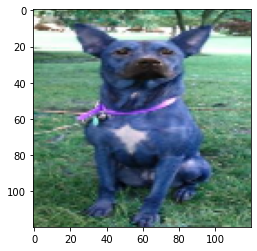

In [5]:
plt.imshow(data[15][0])

In [6]:
X = np.array([value[0] for value in data])
y = np.array([value[1] for value in data])

In [7]:
# Normalize data
X = X / 255

In [ ]:
# Reshape for PyTorch (-1 means unspecified)
X = X.reshape(-1, 3, 120, 120)

In [ ]:
X.shape

In [ ]:
y.shape

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# PyTorch CNN

In [12]:
# Config device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [13]:
# Hyperparameters
BATCH_SIZE = 64
LEARNING_RATE = 0.0002
N_EPOCHS = 5

# Network dims
CONV1_CHANNELS = 64
CONV2_CHANNELS = 64
CONV3_CHANNELS = 128
LINEAR1_SIZE = 128

## Dataset & DataLoader

In [14]:
# Create dataset
class DOGS_VS_CATS(Dataset):
    # Initialise
    def __init__(self, subset='train'):
        super().__init__()
        self.subset = subset
        
        # Store data
        if self.subset=='train':
            self.X = torch.from_numpy(X_train.astype(np.float32))
            self.y = torch.from_numpy(y_train)
        elif self.subset=='valid':
            self.X = torch.from_numpy(X_test.astype(np.float32))
            self.y = torch.from_numpy(y_test)
        elif self.subset=='test':
            self.X = torch.from_numpy(test_data.astype(np.float32))
        else:
            raise Exception("subset must be train, valid or test")
        
    # Get item in position given by index
    def __getitem__(self, index):
        if self.subset == 'test':
            return self.X[index]
        else:
            sample = self.X[index]
        
        return sample, self.y[index]
        
    # Length of dataset 
    def __len__(self):
        return self.X.shape[0]

train_dataset = DOGS_VS_CATS(subset='train')
valid_dataset = DOGS_VS_CATS(subset='valid')

In [15]:
# Dataloaders
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Model

In [16]:
# Convolutional neural network
class ConvNet(nn.Module):
    def __init__(self, conv1_channels=CONV1_CHANNELS, conv2_channels=CONV2_CHANNELS, 
                 conv3_channels=CONV3_CHANNELS, linear1_size=LINEAR1_SIZE):
        super().__init__()
        
        # Layers
        self.conv1=nn.Conv2d(in_channels=3, out_channels=conv1_channels, kernel_size=5, stride=1, padding=2)
        self.pool=nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2=nn.Conv2d(in_channels=conv1_channels, out_channels=conv2_channels, kernel_size=3, stride=1, padding=1)
        self.conv3=nn.Conv2d(in_channels=conv2_channels, out_channels=conv3_channels, kernel_size=3, stride=1, padding=1)
        self.flat=nn.Flatten()
        self.fc1=nn.Linear(in_features=conv3_channels*15*15, out_features=linear1_size)
        self.fc2=nn.Linear(in_features=linear1_size, out_features=2)
        self.relu=nn.ReLU()
        self.softmax=nn.Softmax(dim=1)
        # self.bn = nn.BatchNorm2d()
        
    def forward(self, x):
        
        # Conv block 1
        out = self.conv1(x)
        out = self.relu(out)
        out = self.pool(out)
        
        # Conv block 2
        out = self.conv2(out)
        out = self.relu(out)
        out = self.pool(out)
        
        # Conv block 3
        out = self.conv3(out)
        out = self.relu(out)
        out = self.pool(out)
        
        # Fully connected layer 1
        out = self.flat(out)
        out = self.fc1(out)
        out = self.relu(out)
        
        # Output layer (no softmax needed)
        out = self.fc2(out)
        out = self.softmax(out)
        
        return out

model = ConvNet().to(device)

## Loss

In [17]:
# Cross entropy loss
loss = nn.CrossEntropyLoss()

# Adam optimiser
optimiser = optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

# Learning rate scheduler
scheduler = lr_scheduler.CosineAnnealingLR(optimiser, T_max=N_EPOCHS)

## Train model

In [18]:
%%time

loss_hist = []
val_loss_hist = []

# Loop over epochs
for epoch in range(N_EPOCHS):
    loss_acc = 0
    val_loss_acc = 0
    train_count = 0
    valid_count = 0
    
    # Loop over batches
    for imgs, labels in train_loader:
        # Reshape
        imgs = imgs.to(device)
        labels = labels.to(device)

        # Forward pass
        preds = model(imgs)
        L = loss(preds, labels)

        # Backprop
        L.backward()

        # Update parameters
        optimiser.step()

        # Zero gradients
        optimiser.zero_grad()
        
        # Track loss
        loss_acc += L.detach().item()
        train_count += 1
    
    # Update learning rate
    scheduler.step()
    
    # Don't update weights
    with torch.no_grad():
        # Validate
        for val_imgs, val_labels in valid_loader:
            # Reshape
            val_imgs = val_imgs.to(device)
            val_labels = val_labels.to(device)

            # Forward pass
            val_preds = model(val_imgs)
            val_L = loss(val_preds,val_labels)
            
            # Track loss
            val_loss_acc += val_L.item()
            valid_count += 1
        
    # Save loss history
    loss_hist.append(loss_acc / train_count)
    val_loss_hist.append(val_loss_acc / valid_count)
    
    # Print loss
    print(f'Epoch {epoch + 1} / {N_EPOCHS}, loss {loss_acc / train_count:.5f}, val_loss {val_loss_acc / valid_count:.5f}')
        
print('')
print('Training complete!')

Epoch 1 / 5, loss 0.67987, val_loss 0.65481
Epoch 2 / 5, loss 0.65660, val_loss 0.64609
Epoch 3 / 5, loss 0.63215, val_loss 0.62714
Epoch 4 / 5, loss 0.61692, val_loss 0.62007
Epoch 5 / 5, loss 0.60563, val_loss 0.61419

Training complete!
CPU times: user 1h 31min 25s, sys: 44min 20s, total: 2h 15min 46s
Wall time: 1h 8min 58s


## Evaluate model

In [19]:
model.eval()

with torch.no_grad():
    n_correct=0
    n_samples=0
    
    n_class_correct = [0 for i in range(2)]
    n_class_sample = [0 for i in range(2)]
    
    for imgs, labels in valid_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        output = model(imgs)
        
        _, preds = torch.max(output, 1)
        
        n_samples += labels.shape[0]
        n_correct += (preds == labels).sum().item()
        
        for i in range(BATCH_SIZE):
            try:
                label = labels[i].item()
                pred = preds[i].item()
            except:
                break
            
            if (label == pred):
                n_class_correct[label] += 1
            n_class_sample[label] += 1
    
    acc = 100 * n_correct / n_samples
    print(f'Overall accuracy on test set: {acc:.1f} %')
    
    for i in range(2):
        print(f'Accuracy of {i}: {100* n_class_correct[i] / n_class_sample[i]:.1f} %')

Overall accuracy on test set: 66.6 %
Accuracy of 0: 66.3 %
Accuracy of 1: 67.0 %


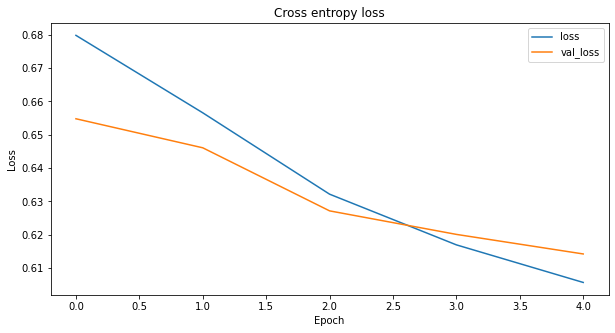

In [20]:
# Plot loss
plt.figure(figsize=(10,5))
plt.plot(loss_hist, c='C0', label='loss')
plt.plot(val_loss_hist, c='C1', label='val_loss')
plt.title('Cross entropy loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Keras CNN

In [16]:
# Reshape for Keras (-1 means unspecified)
X = X.reshape(-1, 120, 120, 3)

In [17]:
X.shape

(25000, 120, 120, 3)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Train model

In [11]:
keras_cnn = keras.Sequential()

# first convolutional layer
keras_cnn.add(layers.Conv2D(filters=64, kernel_size=(3, 3), input_shape=(120, 120, 3), activation="relu"))
keras_cnn.add(layers.MaxPooling2D((2, 2)))

# second convolutional layer
keras_cnn.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu"))
keras_cnn.add(layers.MaxPooling2D((2, 2)))

# third convolutional layer
keras_cnn.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu"))
keras_cnn.add(layers.MaxPooling2D((2, 2)))

keras_cnn.add(layers.Flatten())

keras_cnn.add(layers.Dense(units=128, activation="relu"))

keras_cnn.add(layers.Dense(units=2, activation="softmax"))

2023-01-27 05:55:05.375414: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [12]:
keras_cnn.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics = ["accuracy"]) # sparse or not difference

In [13]:
keras_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 118, 118, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 59, 59, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 57, 57, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 21632)             0

In [19]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)
history = keras_cnn.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test), callbacks=[early_stop])
# keras_cnn.fit(X_train, y_train, batch_size=50, epochs=2, validation_split=0.2, verbose=2)

2023-01-27 05:56:04.714528: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5
625/625 [==============================] - 323s 515ms/step - loss: 0.5852 - accuracy: 0.6790 - val_loss: 0.5090 - val_accuracy: 0.7624
Epoch 2/5
625/625 [==============================] - 311s 497ms/step - loss: 0.4636 - accuracy: 0.7785 - val_loss: 0.4183 - val_accuracy: 0.8002
Epoch 3/5
625/625 [==============================] - 310s 496ms/step - loss: 0.3923 - accuracy: 0.8195 - val_loss: 0.3955 - val_accuracy: 0.8212
Epoch 4/5
625/625 [==============================] - 312s 499ms/step - loss: 0.3202 - accuracy: 0.8597 - val_loss: 0.3948 - val_accuracy: 0.8272
Epoch 5/5
625/625 [==============================] - 308s 492ms/step - loss: 0.2396 - accuracy: 0.9004 - val_loss: 0.4719 - val_accuracy: 0.8180


In [20]:
keras_cnn.evaluate(X_test, y_test)

157/157 [==============================] - 19s 119ms/step - loss: 0.4719 - accuracy: 0.8180


[0.4719444811344147, 0.8180000185966492]

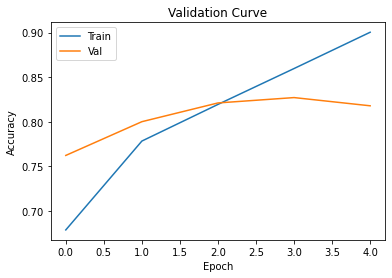

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Validation Curve')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

## Tune hyperparams

In [22]:
def build_model(hp):
    keras_cnn = keras.Sequential()

    # first convolutional layer
    keras_cnn.add(layers.Conv2D(filters=64, kernel_size=(3, 3), input_shape=(120, 120, 3), activation="relu"))
    keras_cnn.add(layers.MaxPooling2D((2, 2)))

    # second convolutional layer
    keras_cnn.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu"))
    keras_cnn.add(layers.MaxPooling2D((2, 2)))

    # third convolutional layer
    keras_cnn.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu"))
    keras_cnn.add(layers.MaxPooling2D((2, 2)))

    keras_cnn.add(layers.Flatten())

    keras_cnn.add(layers.Dense(units=128, activation="relu"))
    
    keras_cnn.add(layers.Dense(units=2, activation="softmax"))
    
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    keras_cnn.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    
    return keras_cnn

In [23]:
tuner = kt.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=3,
    executions_per_trial=1,
    overwrite=True,
    directory="my_dir",
    project_name="cnn",
)

In [24]:
tuner.search_space_summary()

Search space summary
Default search space size: 1
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [25]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)
tuner.search(X_train, y_train, epochs=2, validation_data = (X_test, y_test), callbacks=[early_stop])

Trial 3 Complete [00h 10m 25s]
val_accuracy: 0.8014000058174133

Best val_accuracy So Far: 0.8014000058174133
Total elapsed time: 00h 30m 55s


In [26]:
best_keras_cnn_model = tuner.get_best_models(num_models=1)[0]
best_keras_cnn_model.build(input_shape=(120, 120, 3))
best_keras_cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 118, 118, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 59, 59, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 57, 57, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 21632)             0

In [27]:
tuner.results_summary()

Results summary
Results in my_dir/cnn
Showing 10 best trials
Trial summary
Hyperparameters:
lr: 0.0007919746988842461
Score: 0.8014000058174133
Trial summary
Hyperparameters:
lr: 0.0001799634755009064
Score: 0.8014000058174133
Trial summary
Hyperparameters:
lr: 0.0004936498961125526
Score: 0.7993999719619751


In [28]:
best_keras_cnn_model.fit(X_train, y_train, epochs=2, validation_data = (X_test, y_test), callbacks=[early_stop])

Epoch 1/2
625/625 [==============================] - 321s 512ms/step - loss: 0.3856 - accuracy: 0.8245 - val_loss: 0.3805 - val_accuracy: 0.8280
Epoch 2/2
625/625 [==============================] - 308s 492ms/step - loss: 0.3115 - accuracy: 0.8620 - val_loss: 0.3764 - val_accuracy: 0.8360


In [29]:
best_keras_cnn_model.evaluate(X_test, y_test)

157/157 [==============================] - 18s 113ms/step - loss: 0.3764 - accuracy: 0.8360


[0.3764162063598633, 0.8360000252723694]

# Transfer Learning

In [8]:
# Load Xception without dense layers
base_model = keras.applications.Xception(
    weights='imagenet',
    input_shape=(120, 120, 3),
    include_top=False)

2023-01-27 09:48:22.851789: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib/python3.7/site-packages/cv2/../../lib64:/usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:
2023-01-27 09:48:22.851845: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-27 09:48:22.851896: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (5970faf65323): /proc/driver/nvidia/version does not exist
2023-01-27 09:48:22.852459: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-

In [9]:
# Create dense layers for our classification problem
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
predictions = layers.Dense(2, activation='softmax')(x)

In [10]:
# create final model from 2 parts
model = models.Model(inputs=base_model.input, outputs=predictions)

In [11]:
# freeze convolutional layers of XCeption
base_model.trainable = False

In [12]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 59, 59, 32)   864         ['input_1[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 59, 59, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                              

In [15]:
model.fit(X_train, y_train, epochs=1, validation_data=(X_test, y_test))

2023-01-27 10:08:12.029525: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 3456000000 exceeds 10% of free system memory.


625/625 [==============================] - 851s 1s/step - loss: 0.1885 - accuracy: 0.9182 - val_loss: 0.1558 - val_accuracy: 0.9350


In [16]:
model.evaluate(X_test, y_test)

157/157 [==============================] - 158s 1s/step - loss: 0.1558 - accuracy: 0.9350


[0.1557544767856598, 0.9350000023841858]

## Fine tuning

In [15]:
base_model.trainable = True

In [16]:
model.compile(optimizer=keras.optimizers.Adam(1e-5), 
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [17]:
early_stop = EarlyStopping(monitor='val_loss', patience=2)
model.fit(X_train, y_train, epochs=4, validation_data=(X_test, y_test), callbacks=[early_stop])

Epoch 1/4
625/625 [==============================] - 2017s 3s/step - loss: 0.2684 - accuracy: 0.8903 - val_loss: 0.1463 - val_accuracy: 0.9434
Epoch 2/4
625/625 [==============================] - 2031s 3s/step - loss: 0.1409 - accuracy: 0.9445 - val_loss: 0.1185 - val_accuracy: 0.9550
Epoch 3/4
625/625 [==============================] - 2033s 3s/step - loss: 0.0939 - accuracy: 0.9635 - val_loss: 0.1066 - val_accuracy: 0.9610
Epoch 4/4
625/625 [==============================] - 2028s 3s/step - loss: 0.0644 - accuracy: 0.9766 - val_loss: 0.1048 - val_accuracy: 0.9600


In [18]:
model.evaluate(X_test, y_test)

157/157 [==============================] - 124s 791ms/step - loss: 0.1048 - accuracy: 0.9600


[0.10479971766471863, 0.9599999785423279]

## In the end we get 96% accuracy using Transfer Learning and Fine tuning